In [50]:
# Import necessary libraries
import torch.cuda as torch_cuda
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.utils import make_grid

from torchviz import make_dot

## Verify GPU

In [51]:
print('===VERIFY GPU===')
print('CUDA IS AVAILABLE:', torch_cuda.is_available())
print('DEVICE COUNT:', torch_cuda.device_count())
print('DEVICE NAME:', torch_cuda.get_device_name(0))

# If CUDA is available, print GPU details
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0)} bytes")
    print(f"GPU Memory Cached: {torch.cuda.memory_reserved(0)} bytes")

# Select device: GPU if available, otherwise CPU
device = torch.device('cuda:0' if torch_cuda.is_available() else 'cpu')


===VERIFY GPU===
CUDA IS AVAILABLE: True
DEVICE COUNT: 1
DEVICE NAME: NVIDIA RTX A4000
Number of GPUs: 1
GPU Name: NVIDIA RTX A4000
GPU Memory Allocated: 19442688 bytes
GPU Memory Cached: 25165824 bytes


## Dataset

In [52]:
# Define hyperparameters
batch_size = 16

# Take a subset of the dataset - we are only interested in two classes for now
classes = [0,1] 

# Define transformations: Convert to tensor and normalize
transformations = transforms.Compose([
    transforms.ToTensor()
])

mnist_trainset = datasets.MNIST(
    root='Dataset',
    train=True,
    download=True,
    transform=transformations
)

mnist_testset = datasets.MNIST(
    root='Dataset',
    train=False,
    download=True,
    transform=transformations
)

train_indices = [i for i, label in enumerate(mnist_trainset.targets) if label in classes]
test_indices = [i for i, label in enumerate(mnist_testset.targets) if label in classes]

# Take a subset of the dataset based on the indices we identified as belonging to the class
train_subset = Subset(mnist_trainset, train_indices)
test_subset = Subset(mnist_testset, test_indices)


In [53]:
trainloader = DataLoader(
    train_subset,
    batch_size=batch_size,
    shuffle=True
)

testloader = DataLoader(
    test_subset,
    batch_size=batch_size,
    shuffle=False
)

TRAIN SET LENGTH: 12665
TEST SET LENGTH: 2115


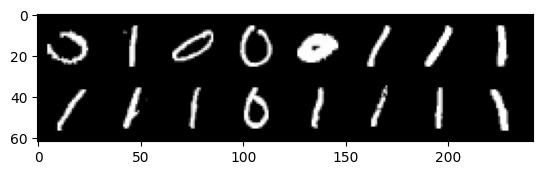

In [54]:
print('TRAIN SET LENGTH:', len(train_subset))
print('TEST SET LENGTH:', len(test_subset))

def imshow(img):

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), vmin=0, vmax=1)
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(make_grid(images))

## AutoEncoder

In [55]:
class AutoEncoder(nn.Module):
    def __init__(self, encoding_dim=60):
        super(AutoEncoder, self).__init__()
        # Encoding from 784 (32*32) to an arbitary number of features
        self.encoder = nn.Linear(784, encoding_dim)
        # Encoding to 784 (32*32) to an arbitary number of features
        self.decoder = nn.Linear(encoding_dim, 784)

    def forward(self, x):
        x = x.reshape(-1, 784)
        x = F.relu(self.encoder(x))
        x = self.decoder(x)
        return x

In [56]:
encoder_epochs = 20
num_dimensions = 50

encoder = AutoEncoder(num_dimensions).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(encoder.parameters())

In [57]:
def train(epoch):
    train_loss = 0.0

    for data in trainloader:
        images, _ = data

        images = images.view(images.size(0), -1)
        images = images.to(device)

        optimizer.zero_grad()

        outputs = encoder(images)

        loss = criterion(outputs, images)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(trainloader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

# Run the training and testing for defined epochs
for epoch in range(encoder_epochs):
    train(epoch)

Epoch: 0 	Training Loss: 0.408307
Epoch: 1 	Training Loss: 0.214819
Epoch: 2 	Training Loss: 0.179398
Epoch: 3 	Training Loss: 0.165918
Epoch: 4 	Training Loss: 0.160328
Epoch: 5 	Training Loss: 0.158207
Epoch: 6 	Training Loss: 0.157730
Epoch: 7 	Training Loss: 0.156468
Epoch: 8 	Training Loss: 0.156009
Epoch: 9 	Training Loss: 0.155904
Epoch: 10 	Training Loss: 0.156082
Epoch: 11 	Training Loss: 0.155706
Epoch: 12 	Training Loss: 0.155363
Epoch: 13 	Training Loss: 0.156100
Epoch: 14 	Training Loss: 0.155478
Epoch: 15 	Training Loss: 0.155516
Epoch: 16 	Training Loss: 0.155644
Epoch: 17 	Training Loss: 0.155044
Epoch: 18 	Training Loss: 0.155638
Epoch: 19 	Training Loss: 0.155341


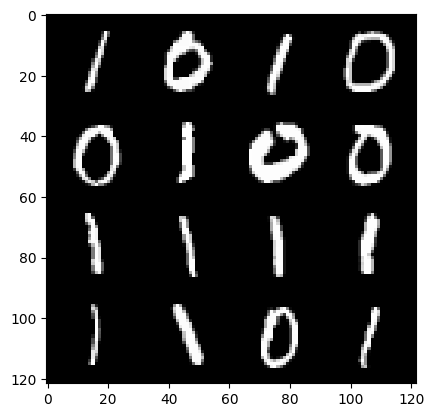

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3049119..1.3659936].


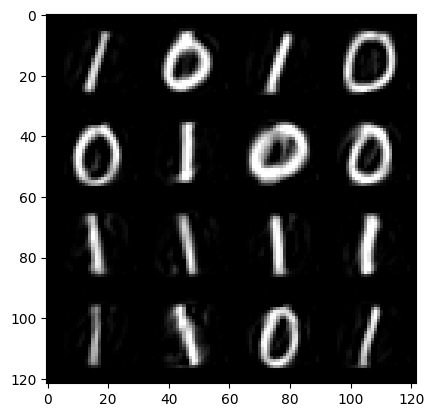

In [58]:
from torchvision.utils import make_grid


def imshow(img):
    npimg = img.numpy()
    #transpose: change array axis to correspond to the plt.imshow() function     
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()

# load 16 images from testset
inputs, _ = next(iter(testloader))
inputs_example = make_grid(inputs[:16,:,:,:],4)
imshow(inputs_example)

#convert from image to tensor
inputs=inputs.cuda()
inputs=torch.reshape(inputs,(-1,784))

# get the outputs from the trained model
outputs=encoder(inputs)

#convert from tensor to image
outputs=torch.reshape(outputs,(-1,1,28,28))
outputs=outputs.detach().cpu()

#show the output images
outputs_example = make_grid(outputs[:16,:,:,:],4)
imshow(outputs_example)

In [59]:
def encode_dataset():
    encoder.eval()
    train_features = []
    train_labels = []
    test_features = []
    test_labels = []

    with torch.no_grad():
      for data, label in trainloader:
          # Get the encoded features (latent space representation)
          encoded = encoder.encoder(data.view(-1, 28 * 28).to(device))
          train_features.append(encoded.to('cpu'))
          train_labels.append(label)

      for data, label in testloader:
          # Get the encoded features (latent space representation)
          encoded = encoder.encoder(data.view(-1, 28 * 28).to(device))
          test_features.append(encoded.to('cpu'))
          test_labels.append(label)

    return torch.cat(train_features, dim=0), torch.cat(test_features, dim=0), torch.cat(train_labels, dim=0), torch.cat(test_labels, dim=0)

features_to_train, features_to_test, labels_to_train, labels_to_test = encode_dataset()

In [60]:
train_dataset = torch.utils.data.TensorDataset(features_to_train, labels_to_train)
test_dataset = torch.utils.data.TensorDataset(features_to_test, labels_to_test)

In [61]:
encoded_trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=False)
encoded_testloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

## Model

In [62]:
momentum_coeff = 0.9
learning_rate = 0.01
learning_decay = 10**-9
epochs = 20

# Classes for MNIST digits
classes = (0,1)

In [154]:
# Define a multi-layer perceptron (MLP) model
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()

        # Define linear layers
        self.input_layer = nn.Linear(num_dimensions, 100)
        self.hidden_layer1 = nn.Linear(100, 100)
        self.hidden_layer2 = nn.Linear(100, 100)
        self.hidden_layer3 = nn.Linear(100, 100)
        self.out = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()

        # Define dropout layers
        self.dropout_layer1 = nn.Dropout(p=0.2)
        self.dropout_layer2 = nn.Dropout(p=0.3)
        self.dropout_layer3 = nn.Dropout(p=0.4)

    def forward(self, x, output=5):
        x = x.reshape(-1, num_dimensions)
        # Pass through layers with ReLU activation and dropout
        x = F.relu(self.input_layer(x))

        x = F.relu(self.hidden_layer1(x))
        if output == 1:
            return x
        x = self.dropout_layer1(x)
        
        x = F.relu(self.hidden_layer2(x))
        if output == 2:
            return x
        x = self.dropout_layer2(x)
        
        x = F.relu(self.hidden_layer3(x))
        if output == 3:
            return x
        x = self.dropout_layer3(x)
        
        x = self.out(x)
        return self.sigmoid(x) 


# Instantiate and move model to the selected device
mlp = MLP().to(device)
loss_function = nn.BCELoss() 
optimizer = optim.SGD(mlp.parameters(), lr=learning_rate,
                      momentum=momentum_coeff, weight_decay=learning_decay)


def train(epoch):
    mlp.train()
    for batch_idx, (data, target) in enumerate(encoded_trainloader):
        data, target = data.to(device), target.to(device, dtype=torch.float32)
        optimizer.zero_grad()
        output = mlp(data)
        output = output.view(-1)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {:>3}\t[{:>5}/{:>5} ({:>3.0f}%)]\tLoss: {:>7.6f}'.format(
                    epoch + 1, batch_idx * len(data), len(encoded_trainloader.dataset),
                    100. * batch_idx / len(encoded_trainloader), loss.item()))

def test():
    mlp.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in encoded_testloader:
            # Move data and targets to device
            
            data, target = data.to(device), target.to(device, dtype=torch.float32)
            # Forward pass
            output = mlp(data)
            output = output.view(-1)
            # Compute loss and accumulate
            test_loss += loss_function(output, target).item()
            # Get predicted classes
            pred = (output > 0.5).float()
            # Count how many predictions are correct
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(encoded_testloader)
    print('\nTest set: Average loss: {:>10.4f}, Accuracy: {:>5}/{:>5} ({:>3.3f}%)\n'.format(
        test_loss, correct, len(encoded_testloader.dataset),
        100. * correct / len(encoded_testloader.dataset)))


# Run the training and testing for defined epochs
for epoch in range(epochs):
    train(epoch)
    test()


Train Epoch:   1	[    0/12665 (  0%)]	Loss: 0.683618
Train Epoch:   1	[ 3200/12665 ( 25%)]	Loss: 0.017962
Train Epoch:   1	[ 6400/12665 ( 51%)]	Loss: 0.001631
Train Epoch:   1	[ 9600/12665 ( 76%)]	Loss: 0.003819

Test set: Average loss:     0.0125, Accuracy:  2110/ 2115 (99.764%)

Train Epoch:   2	[    0/12665 (  0%)]	Loss: 0.000359
Train Epoch:   2	[ 3200/12665 ( 25%)]	Loss: 0.005528
Train Epoch:   2	[ 6400/12665 ( 51%)]	Loss: 0.000684
Train Epoch:   2	[ 9600/12665 ( 76%)]	Loss: 0.008445

Test set: Average loss:     0.0064, Accuracy:  2112/ 2115 (99.858%)

Train Epoch:   3	[    0/12665 (  0%)]	Loss: 0.000409
Train Epoch:   3	[ 3200/12665 ( 25%)]	Loss: 0.009549
Train Epoch:   3	[ 6400/12665 ( 51%)]	Loss: 0.000840
Train Epoch:   3	[ 9600/12665 ( 76%)]	Loss: 0.007715

Test set: Average loss:     0.0032, Accuracy:  2113/ 2115 (99.905%)

Train Epoch:   4	[    0/12665 (  0%)]	Loss: 0.000156
Train Epoch:   4	[ 3200/12665 ( 25%)]	Loss: 0.001470
Train Epoch:   4	[ 6400/12665 ( 51%)]	Loss: 0.00

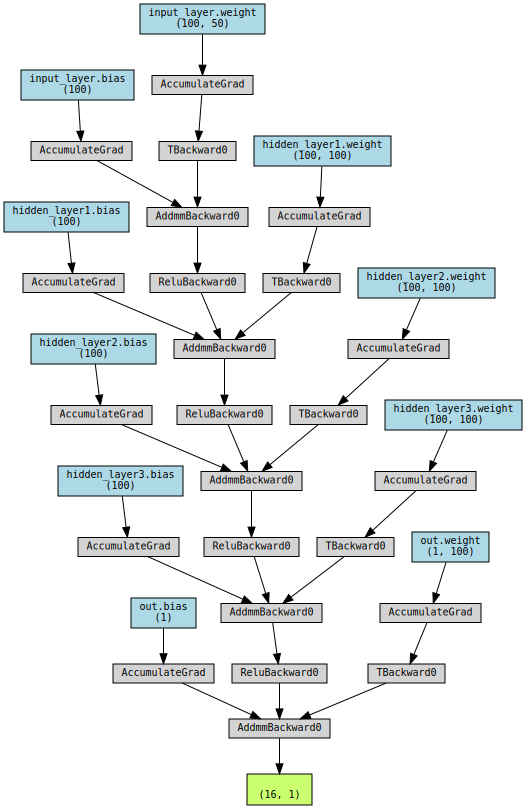

In [89]:
make_dot(mlp(next(iter(encoded_testloader))[0].to(device)), params=dict(mlp.named_parameters()))

## SHAP

In [159]:
images = []
labels = []

for batch_idx, (image_batch, label_batch) in enumerate(encoded_trainloader):
    for i in range(0, batch_size):
        images.append(image_batch[i])
        labels.append(label_batch[i])
    if len(images) >= 200:
        break

background_images = np.array(images[:200])
test = np.array(images[200:])
background = torch.from_numpy(background_images)
test = torch.from_numpy(test)

test_out = mlp(background.to(device))
test_out

tensor([[1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0862e-07],
        [1.0000e+00],
        [1.3597e-08],
        [3.5035e-12],
        [1.0000e+00],
        [1.0000e+00],
        [6.1134e-12],
        [2.3553e-07],
        [6.1926e-10],
        [9.9977e-01],
        [1.4252e-08],
        [4.3111e-09],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [9.0591e-11],
        [7.1769e-11],
        [2.0069e-10],
        [1.0000e+00],
        [1.6662e-10],
        [3.8109e-07],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [9.9999e-01],
        [6.0621e-07],
        [1.0000e+00],
        [1.1001e-07],
        [1.0000e+00],
        [9.9989e-01],
        [6.8160e-04],
        [7.5935e-06],
        [1.0000e+00],
        [1.5604e-11],
        [1.0437e-08],
        [9.9999e-01],
        [1.0000e+00],
        [1

In [160]:
import shap

e = shap.DeepExplainer(mlp, background.to(device))
shap_values = e.shap_values(test.to(device))

AssertionError: The SHAP explanations do not sum up to the model's output! This is either because of a rounding error or because an operator in your computation graph was not fully supported. If the sum difference of %f is significant compared to the scale of your model outputs, please post as a github issue, with a reproducible example so we can debug it. Used framework: pytorch - Max. diff: 0.21990141303547261 - Tolerance: 0.01

## Dimensionality Reduction

In [ ]:
def get_activations(layer = 4):
    activations = []
    labels = []
    predictions = []
    with torch.no_grad():

        #  Train Data Activations
        for data, target in trainloader:
            # Move data and targets to device
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = mlp(data, output=layer)
            for t in output:
                activations.append(t.to('cpu').numpy())
            target_arr = target.to('cpu').numpy()
            if len(target_arr) != batch_size:
                target_arr = np.pad(target_arr, (0, batch_size - len(target_arr)), mode='constant', constant_values=-1)
            labels.append(target_arr)

            output = mlp(data, output=5)
            for t in output:
                pred = np.argmax(t.to('cpu').numpy())
                predictions.append(pred)

        #  Test Data Activations
        for data, target in testloader:
            # Move data and targets to device
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = mlp(data, output=layer)
            for t in output:
                activations.append(t.to('cpu').numpy())
            target_arr = target.to('cpu').numpy()
            if len(target_arr) != batch_size:
                target_arr = np.pad(target_arr, (0, batch_size - len(target_arr)), mode='constant', constant_values=-1)
            labels.append(target_arr)

            output = mlp(data, output=5)
            for t in output:
                pred = np.argmax(t.to('cpu').numpy())
                predictions.append(pred)

    return activations, labels, predictions

activations, labels, predictions = get_activations(4)

[ 0  1  0  0  1  1  1  1  0 -1 -1 -1 -1 -1 -1 -1]
[ 1  0  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [ ]:
flat_labels = np.array(labels).flatten()
cleaned_labels = [i for i in flat_labels if i != -1]

In [ ]:
activations = np.array(activations)

predictions_df = pd.DataFrame(predictions, columns=['prediction'])
labels_df = pd.DataFrame(np.array(cleaned_labels).flatten(), columns=['class'])

,class
0,0
1,1
2,0
3,1
4,0


In [ ]:
from sklearn.manifold import TSNE

dim_red = TSNE(n_components = 2, random_state=0)
points = dim_red.fit_transform(activations)
points

array([[ 47.254368,  27.1345  ],
       [-28.813904, -22.195187],
       [ 67.71189 , -44.11951 ],
       ...,
       [-76.20368 ,  -6.519619],
       [ 61.03111 , -10.029565],
       [-91.674515,  -6.153782]], dtype=float32)

### Quick Plot

<Axes: xlabel='x', ylabel='y'>

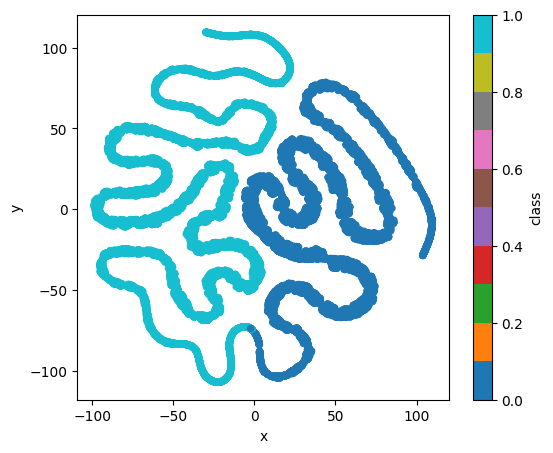

In [82]:
# Quick plot to check data
points_df = pd.DataFrame(points, columns=['x','y']).join(labels_df).join(predictions_df)

plt.rcParams["figure.figsize"] = [6, 5]
points_df.plot.scatter(
    x='x',
    y='y',
    c='class',
    colormap='tab10'
)